URL del dataset:

https://www.kaggle.com/christianlillelund/csgo-round-winner-classification
    

Aclaracion: Cada una de las observaciones del dataset, describe el estado de una ronda y por lo tanto pueden tratarse individualmente. Aunque se pueden haber tomado distintas observaciones que pertenecen a la misma ronda.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier 
from lightgbm import plot_importance

from lime.lime_tabular import LimeTabularExplainer


pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# Importamos los datos

data = pd.read_csv('Data/cs_go_grupo5.csv', index_col='Unnamed: 0')

df = data.copy()

In [3]:
df.head()

time_left  ct_score  t_score       map  bomb_planted  ct_health  t_health  \
0     175.00       0.0      0.0  de_dust2         False      500.0     500.0   
1     156.03       0.0      0.0  de_dust2         False      500.0     500.0   
2      96.03       0.0      0.0  de_dust2         False      391.0     400.0   
3      76.03       0.0      0.0  de_dust2         False      391.0     400.0   
4     174.97       1.0      0.0  de_dust2         False      500.0     500.0   

   ct_armor  t_armor  ct_money  t_money  ct_helmets  t_helmets  \
0       0.0      0.0    4000.0   4000.0         0.0        0.0   
1     400.0    300.0     600.0    650.0         0.0        0.0   
2     294.0    200.0     750.0    500.0         0.0        0.0   
3     294.0    200.0     750.0    500.0         0.0        0.0   
4     192.0      0.0   18350.0  10750.0         0.0        0.0   

   ct_defuse_kits  ct_players_alive  t_players_alive  ct_weapon_ak47  \
0             0.0               5.0              5.0             0.0   
1             1.0               5.0              5.0             0.0   
2             1.0               4.0              4.0             0.0   
3             1.0               4.0              4.0             0.0   
4             1.0               5.0              5.0             0.0   

   t_weapon_ak47  ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
0            0.0            0.0           0.0            0.0           0.0   
1            0.0            0.0           0.0            0.0           0.0   
2            0.0            0.0           0.0            0.0           0.0   
3            0.0            0.0           0.0            0.0           0.0   
4            0.0            0.0           0.0            0.0           0.0   

   ct_weapon_bizon  t_weapon_bizon  ct_weapon_cz75auto  t_weapon_cz75auto  \
0              0.0             0.0                 0.0                0.0   
1              0.0             0.0                 0.0                0.0   
2              0.0             0.0                 0.0                0.0   
3              0.0             0.0                 0.0                0.0   
4              0.0             0.0                 0.0                0.0   

   ct_weapon_elite  t_weapon_elite  ct_weapon_famas  t_weapon_famas  \
0              0.0             0.0              0.0             0.0   
1              0.0             0.0              0.0             0.0   
2              0.0             0.0              0.0             0.0   
3              0.0             0.0              0.0             0.0   
4              0.0             0.0              0.0             0.0   

   ct_weapon_g3sg1  t_weapon_g3sg1  ct_weapon_galilar  t_weapon_galilar  \
0              0.0             0.0                0.0               0.0   
1              0.0             0.0                0.0               0.0   
2              0.0             0.0                0.0               0.0   
3              0.0             0.0                0.0               0.0   
4              0.0             0.0                0.0               0.0   

   ct_weapon_glock  t_weapon_glock  ct_weapon_m249  t_weapon_m249  \
0              0.0             5.0             0.0            0.0   
1              0.0             5.0             0.0            0.0   
2              0.0             4.0             0.0            0.0   
3              0.0             3.0             0.0            0.0   
4              0.0             5.0             0.0            0.0   

   ct_weapon_m4a1s  t_weapon_m4a1s  ct_weapon_m4a4  t_weapon_m4a4  \
0              0.0             0.0             0.0            0.0   
1              0.0             0.0             0.0            0.0   
2              0.0             0.0             0.0            0.0   
3              0.0             0.0             0.0            0.0   
4              0.0             0.0             0.0            0.0   

   ct_weapon_mac10  t_weapon_mac10  ct_weapon_mag7  

# EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     121054 non-null  float64
 1   ct_score                      121054 non-null  float64
 2   t_score                       121054 non-null  float64
 3   map                           121054 non-null  object 
 4   bomb_planted                  121054 non-null  bool   
 5   ct_health                     121054 non-null  float64
 6   t_health                      121054 non-null  float64
 7   ct_armor                      121054 non-null  float64
 8   t_armor                       121054 non-null  float64
 9   ct_money                      121054 non-null  float64
 10  t_money                       121054 non-null  float64
 11  ct_helmets                    121054 non-null  float64
 12  t_helmets                     121054 non-nul

In [5]:
# Chequeamos si hay datos faltantes

df.isnull().any().any()

False

In [6]:
df.describe()

time_left       ct_score        t_score      ct_health  \
count  121054.000000  121054.000000  121054.000000  121054.000000   
mean       97.779809       6.697152       6.768888     412.612892   
std        54.274380       4.791150       4.824726     131.805923   
min         0.010000       0.000000       0.000000       1.000000   
25%        54.920000       3.000000       3.000000     353.000000   
50%        94.910000       6.000000       6.000000     500.000000   
75%       166.910000      10.000000      10.000000     500.000000   
max       175.000000      32.000000      33.000000     500.000000   

            t_health       ct_armor        t_armor       ct_money  \
count  121054.000000  121054.000000  121054.000000  121054.000000   
mean      403.256034     316.213632     300.425488    9835.801378   
std       139.401569     170.006382     173.772098   11223.205878   
min         0.000000       0.000000       0.000000       0.000000   
25%       324.000000     195.000000     178.000000    1250.000000   
50%       500.000000     380.000000     341.000000    5600.000000   
75%       500.000000     486.000000     469.000000   14700.000000   
max       500.000000     500.000000     500.000000   80000.000000   

             t_money     ct_helmets      t_helmets  ct_defuse_kits  \
count  121054.000000  121054.000000  121054.000000   121054.000000   
mean    11299.019446       2.065822       2.790845        1.621863   
std     12175.515454       1.841998       2.008555        1.606205   
min         0.000000       0.000000       0.000000        0.000000   
25%      1550.000000       0.000000       0.000000        0.000000   
50%      7300.000000       2.000000       3.000000        1.000000   
75%     18150.000000       4.000000       5.000000        3.000000   
max     80000.000000       5.000000       5.000000        5.000000   

       ct_players_alive  t_players_alive  ct_weapon_ak47  t_weapon_ak47  \
count     121054.000000    121054.000000   121054.000000  121054.000000   
mean           4.278677         4.271482        0.275356       1.251442   
std            1.200535         1.223086        0.585206       1.365961   
min            1.000000         0.000000        0.000000       0.000000   
25%            4.000000         4.000000        0.000000       0.000000   
50%            5.000000         5.000000        0.000000       1.000000   
75%            5.000000         5.000000        0.000000       2.000000   
max            5.000000         5.000000        4.000000       5.000000   

       ct_weapon_aug   t_weapon_aug  ct_weapon_awp   t_weapon_awp  \
count  121054.000000  121054.000000  121054.000000  121054.000000   
mean        0.135320       0.007592       0.576420       0.322154   
std         0.461609       0.091163       0.673945       0.476927   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       1.000000       1.000000   
max         5.000000       3.000000       5.000000       4.000000   

       ct_weapon_bizon  t_weapon_bizon  ct_weapon_cz75auto  t_weapon_cz75auto  \
count         121054.0   121054.000000       121054.000000      121054.000000   
mean               0.0        0.000083            0.152618           0.106308   
std                0.0        0.009089            0.446796           0.380639   
min                0.0        0.000000            0.000000           0.000000   
25%                0.0        0.000000            0.000000           0.000000   
50%                0.0        0.000000            0.000000           0.000000   
75%                0.0        0.000000            0.000000           0.000000   
max                0.0        1.000000            5.000000           6.000000   

       ct_weapon_elite  t_weapon_elite  ct_weapon_famas  t_weapon_famas  \
count     121054.00000   121054.0

In [7]:
# Convierto a categorico las features que corresponden

df.map=(df.map).astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   time_left                     121054 non-null  float64 
 1   ct_score                      121054 non-null  float64 
 2   t_score                       121054 non-null  float64 
 3   map                           121054 non-null  category
 4   bomb_planted                  121054 non-null  bool    
 5   ct_health                     121054 non-null  float64 
 6   t_health                      121054 non-null  float64 
 7   ct_armor                      121054 non-null  float64 
 8   t_armor                       121054 non-null  float64 
 9   ct_money                      121054 non-null  float64 
 10  t_money                       121054 non-null  float64 
 11  ct_helmets                    121054 non-null  float64 
 12  t_helmets                     

### DISCRETIZAMOS EL TARGET


In [9]:

df['round_winner'] = df['round_winner'].map({'CT':0, 'T':1})

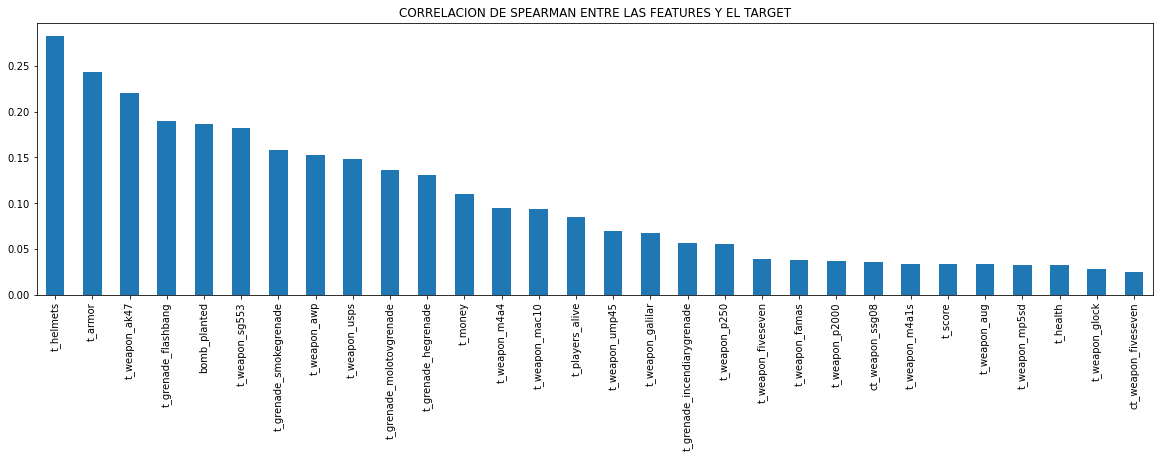

In [10]:
# Correlacion de Spearman es que cuando una feature aumenta, el valor del target aumenta 
# y viceversa, cuando el valor de una feature disminuye, el target, disminuye

features_spearman_correlation=(df.corr(method='spearman'))['round_winner'].drop(index='round_winner').sort_values(ascending = False)[:30]

features_spearman_correlation.plot(kind='bar', figsize=(20,5), title = 'CORRELACION DE SPEARMAN ENTRE LAS FEATURES Y EL TARGET')

plt.show()


In [11]:
features_con_mayor_spearman_correlation=(df.corr(method='spearman'))['round_winner'].drop(index='round_winner').sort_values(ascending = False)[:5].index

features_con_mayor_spearman_correlation=pd.concat([df[features_con_mayor_spearman_correlation], df['round_winner']], axis=1)



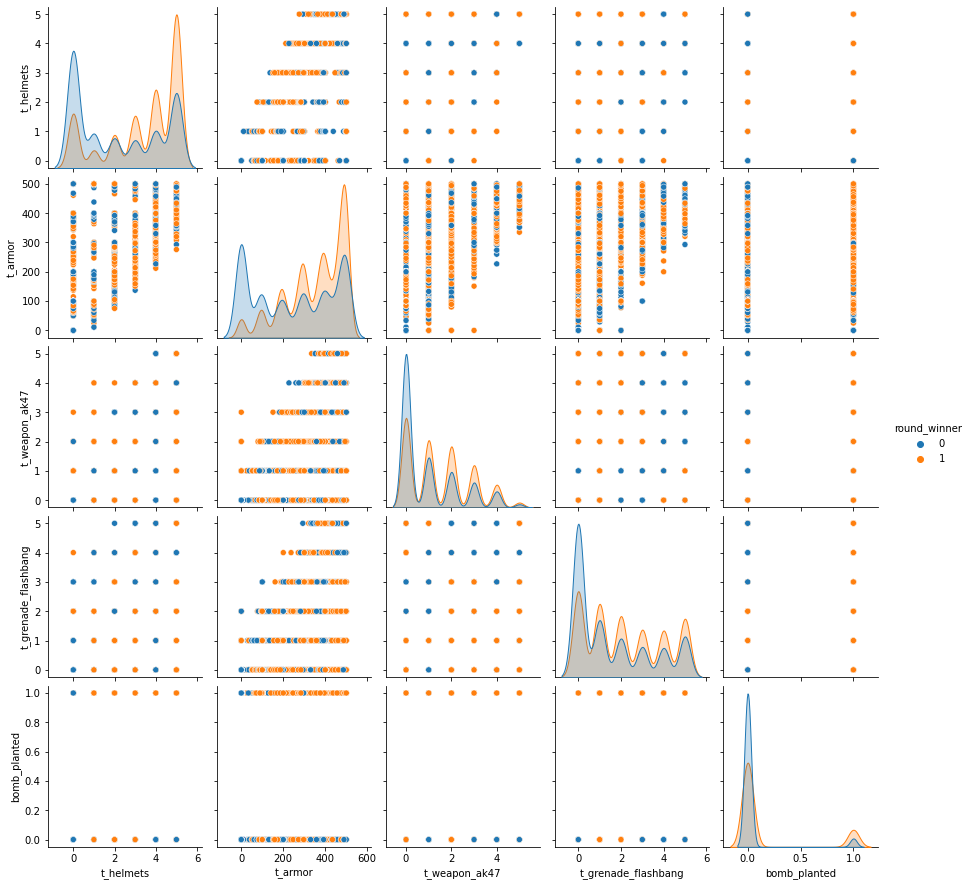

In [12]:
features_con_mayor_spearman_correlation = features_con_mayor_spearman_correlation.sample(frac=0.25, random_state = 1204)

sns.pairplot(features_con_mayor_spearman_correlation, hue = 'round_winner')

plt.show()

La compra de cascos, pareciera beneficiar mas al equipo `Terrorist` que al `Counter-Terrorist`

La compra de ct_granadas flashbang, parece ayudar bastante al equipo `Counter-Terrorist` a repeler el ataque `Terrorist`

### ESTUDIAMOS LA DISTRIBUCION DE LA VARIABLE TARGET


In [13]:
df['round_winner'].value_counts(normalize = True)

1    0.51007
0    0.48993
Name: round_winner, dtype: float64

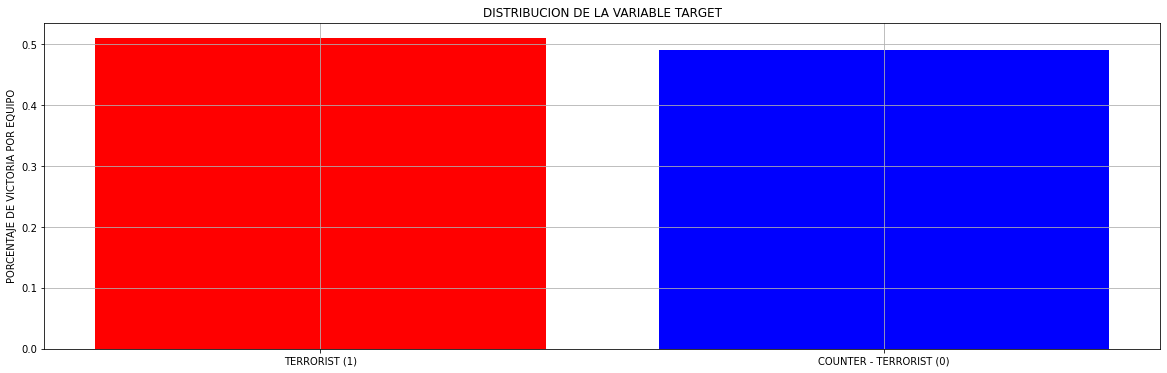

In [14]:
plt.figure(figsize=(20,6)); ax = plt.axes()
ax.bar(x= ['TERRORIST (1)', 'COUNTER - TERRORIST (0)'], height=df['round_winner'].value_counts(normalize = True), color=['r','b'])
plt.title('DISTRIBUCION DE LA VARIABLE TARGET')
plt.ylabel('PORCENTAJE DE VICTORIA POR EQUIPO')
plt.grid()

plt.show()

**Parecen estar bastante balanceados ambos lados de juego, tanto el atacante como el defensor.**

### ESTUDIAMOS QUE MAPAS FUERON UTILIZADOS Y SU RELACION CON EL TARGET

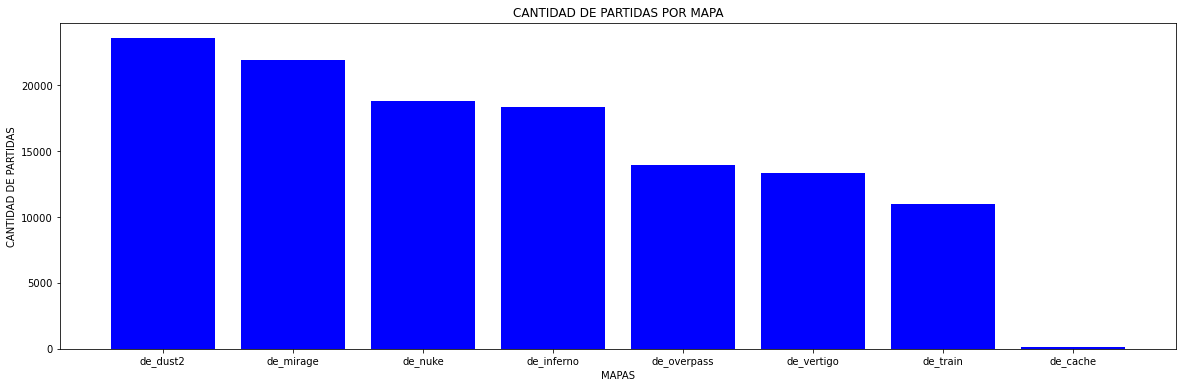

In [15]:
plt.figure(figsize=(20,6)); ax = plt.axes()
ax.bar(x= df.map.unique(),height=df.map.value_counts(), color='b')
plt.xlabel('MAPAS')
plt.ylabel('CANTIDAD DE PARTIDAS')
plt.title('CANTIDAD DE PARTIDAS POR MAPA')

plt.show()

In [16]:
mapas = df.map.unique()

ct_winrate_map=[df[df.map == mapa]['round_winner'].value_counts(normalize= True)[0] for mapa in mapas]
t_winrate_map=[df[df.map == mapa]['round_winner'].value_counts(normalize= True)[1] for mapa in mapas]

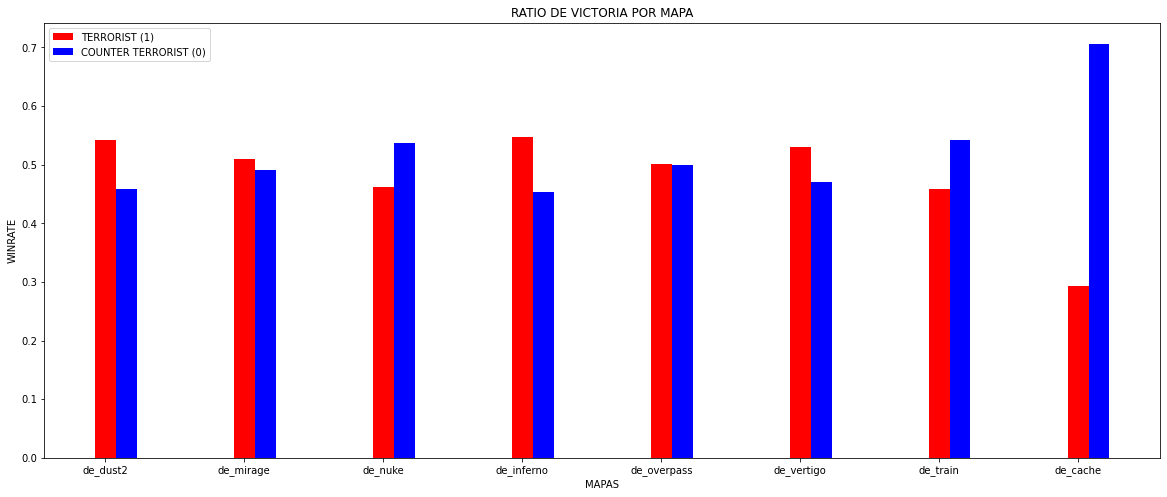

In [17]:
ind = np.arange(8) # crea la lista con numeros entre 0 y 4
width = 0.15 # ancho de las barras

fig = plt.figure(figsize=(20,8)); ax = plt.axes()
ax.bar(ind+ 0.00, t_winrate_map, width, color='r') # barra roja. 
ax.bar(ind+ 0.15, ct_winrate_map, width, color='b') # barra azul 


ax.set_title('RATIO DE VICTORIA POR MAPA')
ax.set_ylabel('WINRATE')
ax.set_xlabel('MAPAS')
ax.set_xticks(ind)
ax.set_xticklabels(mapas)
ax.legend(labels=['TERRORIST (1)', 'COUNTER TERRORIST (0)'])
# sns.set(font_scale = 1.5)
plt.show()

Vemos una gran ventaja para defender en el mapa `de_cache`, pero, fue muy poco utilizado

Vemos que estan bastante equilibrados los ratios entre ambos lados en los demas mapas

### ESTUDIAMOS LA BOMBA EN FUNCION DEL TARGET 

###### PORCENTAJE DE BOMBA PLANTADA EN LA PARTIDA

In [18]:
round(((df[df.bomb_planted==1].shape[0]/ df.shape[0])*100),2)

11.08

*Se planto la bomba en un 11% de las partidas*

In [19]:
victorias_bomba_plantada = pd.DataFrame(df.groupby('round_winner')['bomb_planted'].sum())

victorias_bomba_plantada['PORCENTAJE DE VICTORIA %'] = ((victorias_bomba_plantada['bomb_planted']/(victorias_bomba_plantada.sum()[0])*100).round(2))

victorias_bomba_plantada.rename(columns = {'bomb_planted':'VECES QUE FUE PLANTADA DE LA BOMBA'}, inplace=True)

victorias_bomba_plantada.index = ['COUNTER-TERRORIST','TERRORIST']

victorias_bomba_plantada

VECES QUE FUE PLANTADA DE LA BOMBA  \
COUNTER-TERRORIST                                3021   
TERRORIST                                       10391   

                   PORCENTAJE DE VICTORIA %  
COUNTER-TERRORIST                     22.52  
TERRORIST                             77.48

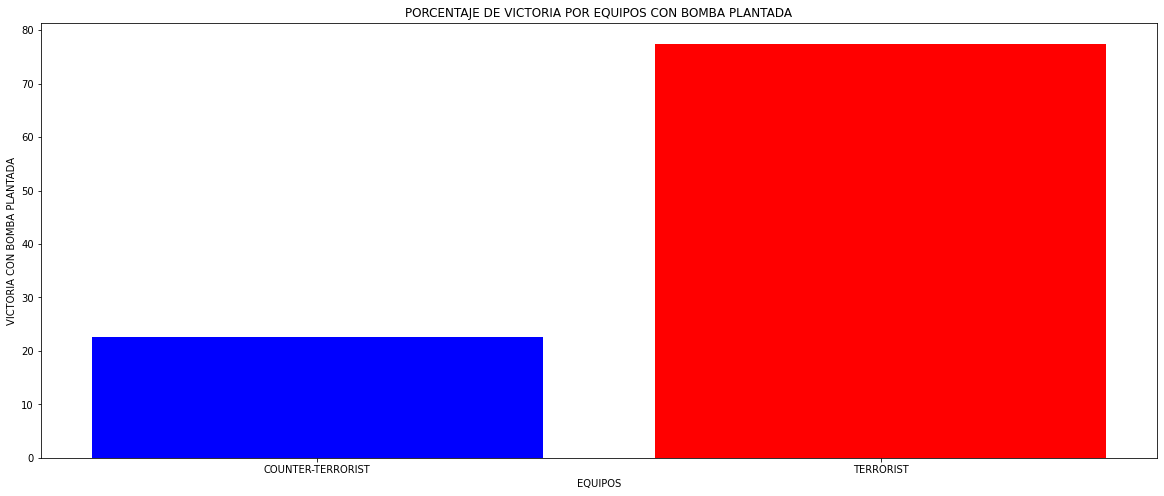

In [20]:
bomba = plt.figure(figsize=(20,8)); bomba_axes = plt.axes()

bomba_axes = plt.bar(x = victorias_bomba_plantada.index , height=victorias_bomba_plantada['PORCENTAJE DE VICTORIA %'], color = ['b','r'])

plt.xlabel('EQUIPOS')
plt.ylabel('VICTORIA CON BOMBA PLANTADA')
plt.title('PORCENTAJE DE VICTORIA POR EQUIPOS CON BOMBA PLANTADA')

plt.show()

Podemos ver una muy gran probabilidad de victoria del equipo `Terrorist` cuando logra plantar la bomba

In [21]:
class Discretizador_bomb (TransformerMixin, BaseEstimator):
    
    def __init__(self, bomb_feature):
        self.bomb_feature = bomb_feature
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame((X[self.bomb_feature]).astype(int), columns = ['bomb_planted'])
    
    
class Feature_selector(TransformerMixin, BaseEstimator):
    
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X[self.features], columns = self.features)
    
class Make_dummies(TransformerMixin, BaseEstimator):
    
    def __init__(self, to_dummy):
        self.to_dummy = to_dummy
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(data=X[self.to_dummy] ,drop_first = False, columns = self.to_dummy)
    

In [22]:
mapa_steps = [('encodeo', Make_dummies('map'))]

mapa_pipe = Pipeline(mapa_steps)

In [23]:
discretizador_steps = [('discretizacion_bomb', Discretizador_bomb('bomb_planted'))]

discretizador_pipe = Pipeline(discretizador_steps)

df['bomb_planted'] = discretizador_pipe.fit_transform(df)

In [24]:
# Vamos a unir todo 

union = make_union(mapa_pipe,
                   discretizador_pipe,
                   Feature_selector(df.drop(['map','bomb_planted','round_winner'], axis=1).columns.values))

In [25]:
# voy a crearme un df, para obtener las features, para luego usarlas para nombrar el dataframe feature_importance_

df_mapa = mapa_pipe.fit_transform(df)
df_discretizador = discretizador_pipe.fit_transform(df)
df_resto = Feature_selector(df.drop(['map','bomb_planted','round_winner'], axis=1).columns.values).fit_transform(df)

df_combinacion = pd.concat([df_mapa,df_discretizador,df_resto], axis=1)

df_combinacion.head(3)

de_cache  de_dust2  de_inferno  de_mirage  de_nuke  de_overpass  de_train  \
0         0         1           0          0        0            0         0   
1         0         1           0          0        0            0         0   
2         0         1           0          0        0            0         0   

   de_vertigo  bomb_planted  time_left  ct_score  t_score  ct_health  \
0           0             0     175.00       0.0      0.0      500.0   
1           0             0     156.03       0.0      0.0      500.0   
2           0             0      96.03       0.0      0.0      391.0   

   t_health  ct_armor  t_armor  ct_money  t_money  ct_helmets  t_helmets  \
0     500.0       0.0      0.0    4000.0   4000.0         0.0        0.0   
1     500.0     400.0    300.0     600.0    650.0         0.0        0.0   
2     400.0     294.0    200.0     750.0    500.0         0.0        0.0   

   ct_defuse_kits  ct_players_alive  t_players_alive  ct_weapon_ak47  \
0             0.0               5.0              5.0             0.0   
1             1.0               5.0              5.0             0.0   
2             1.0               4.0              4.0             0.0   

   t_weapon_ak47  ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
0            0.0            0.0           0.0            0.0           0.0   
1            0.0            0.0           0.0            0.0           0.0   
2            0.0            0.0           0.0            0.0           0.0   

   ct_weapon_bizon  t_weapon_bizon  ct_weapon_cz75auto  t_weapon_cz75auto  \
0              0.0             0.0                 0.0                0.0   
1              0.0             0.0                 0.0                0.0   
2              0.0             0.0                 0.0                0.0   

   ct_weapon_elite  t_weapon_elite  ct_weapon_famas  t_weapon_famas  \
0              0.0             0.0              0.0             0.0   
1              0.0             0.0              0.0             0.0   
2              0.0             0.0              0.0             0.0   

   ct_weapon_g3sg1  t_weapon_g3sg1  ct_weapon_galilar  t_weapon_galilar  \
0              0.0             0.0                0.0               0.0   
1              0.0             0.0                0.0               0.0   
2              0.0             0.0                0.0               0.0   

   ct_weapon_glock  t_weapon_glock  ct_weapon_m249  t_weapon_m249  \
0              0.0             5.0             0.0            0.0   
1              0.0             5.0             0.0            0.0   
2              0.0             4.0             0.0            0.0   

   ct_weapon_m4a1s  t_weapon_m4a1s  ct_weapon_m4a4  t_weapon_m4a4  \
0              0.0             0.0             0.0            0.0   
1              0.0             0.0             0.0            0.0   
2              0.0             0.0             0.0            0.0   

   ct_weapon_mac10  t_weapon_mac10  ct_weapon_mag7  t_weapon_mag7  \
0              0.0             0.0             0.0            0.0   
1              0.0             0.0             0.0            0.0   
2              0.0             0.0             0.0            0.0   

   ct_weapon_mp5sd  t_weapon_mp5sd  ct_weapon_mp7  t_weapon_mp7  \
0              0.0             0.0            0.0           0.0   
1              0.0             0.0            0.0           0.0   
2              0.0             0.0            0.0           0.0   

   ct_weapon_mp9  t_weapon_mp9  ct_weapon_negev  t_weapon_negev  \
0            0.0           0.0              0.0             0.0   
1            0.0           0.0              0.0             0.0   
2            0.0           0.0              0.0             0.0   

   ct_weapon_nova  t_weapon_nova  ct_weapon_p90  t_weapon_p90  \
0             0.0            0.0            0.0           0.0   
1             0.0            0.0            0.0           0.0   
2             0.0          

In [26]:
# Separamos la variable target, de las variables explicativas

X = pd.DataFrame(union.fit_transform(df))
y = df.round_winner


In [27]:
X.head()

0    1    2    3    4    5    6    7    8       9    10   11     12   \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  175.00  0.0  0.0  500.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  156.03  0.0  0.0  500.0   
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   96.03  0.0  0.0  391.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   76.03  0.0  0.0  391.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  174.97  1.0  0.0  500.0   

     13     14     15       16       17   18   19   20   21   22   23   24   \
0  500.0    0.0    0.0   4000.0   4000.0  0.0  0.0  0.0  5.0  5.0  0.0  0.0   
1  500.0  400.0  300.0    600.0    650.0  0.0  0.0  1.0  5.0  5.0  0.0  0.0   
2  400.0  294.0  200.0    750.0    500.0  0.0  0.0  1.0  4.0  4.0  0.0  0.0   
3  400.0  294.0  200.0    750.0    500.0  0.0  0.0  1.0  4.0  4.0  0.0  0.0   
4  500.0  192.0    0.0  18350.0  10750.0  0.0  0.0  1.0  5.0  5.0  0.0  0.0   

   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   \
0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   

   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99   \
0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   100  101  102  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0

In [28]:
y.shape

(121054,)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1203)


In [30]:
X_train.head()

0    1    2    3    4    5    6    7    8       9     10   11     12   \
1741   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   54.95   5.0  7.0  400.0   
34656  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   74.91  15.0  6.0  491.0   
49119  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   19.80   3.0  7.0   30.0   
69085  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  175.00  11.0  9.0  500.0   
49895  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   94.94   0.0  0.0  400.0   

         13     14     15       16       17   18   19   20   21   22   23   \
1741   259.0  383.0  298.0   5000.0  24250.0  1.0  4.0  1.0  4.0  4.0  1.0   
34656  472.0  496.0  498.0  11700.0    500.0  5.0  4.0  5.0  5.0  5.0  0.0   
49119  231.0   99.0  249.0    150.0  22500.0  1.0  3.0  0.0  1.0  3.0  0.0   
69085  500.0  200.0  430.0  10200.0  16950.0  1.0  5.0  0.0  5.0  5.0  0.0   
49895  500.0  400.0  300.0    600.0    850.0  0.0  0.0  0.0  4.0  5.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36   37   \
1741   1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49119  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  3.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       38   39   40   41   42   43   44   45   46   47   48   49   50   51   \
1741   0.0  0.0  0.0  0.0  3.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  1.0  0.0  4.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  1.0  0.0   
49119  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       52   53   54   55   56   57   58   59   60   61   62   63   64   65   \
1741   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49119  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       66   67   68   69   70   71   72   73   74   75   76   77   78   79   \
1741   0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  0.0  0.0  0.0  3.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
49119  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       80   81   82   83   84   85   86   87   88   89   90   91   92   93   \
1741   0.0  0.0  0.0  3.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   
34656  1.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  3.0   
49119  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0   
49895  0.0  0.0  0.0  3.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

       94   95   96   97   98   99   100  101  102  
1741   2.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  
34656  1.0  3.0  2.0  3.0  0.0  0.0  1.0  0.0  0.0  
49119  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
69085  5.0  0.0  5.0  0.0  0.0  0.0  5.0  0.0  0.0  
49895  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [31]:
y_train.head()

1755     1
35026    0
49663    1
69887    1
50449    0
Name: round_winner, dtype: int64

## INSTANCIAMOS UN CLASIFICADOR BASELINE

In [32]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

accuracy_score(y_test, dc.predict(X_test))

0.5100779804388051

###### **Nuestro dataset dio un baseline del 51%**

## CREAMOS NUESTRO MODELO

In [33]:
# steps_modelo = [('estandarizacion', StandardScaler()),
#                 ('estimador', CatBoostClassifier())]

In [34]:
steps_modelo = [('estandarizacion', StandardScaler()),
                ('estimador', LGBMClassifier(importance_type='gain'))]



In [35]:
pipe_modelo = Pipeline(steps_modelo)

In [36]:
pipe_modelo.fit(X_train, y_train)

Pipeline(steps=[('estandarizacion', StandardScaler()),
                ('estimador', LGBMClassifier(importance_type='gain'))])

In [37]:
# Accuracy del modelo, sin usar gridsearch

accuracy_score(y_test, pipe_modelo.predict(X_test))

0.7786478984932593

In [38]:
# Ahora vamos a utilizar GridSearch para tunear nuestro modelo

param_grid = [{'estandarizacion':[StandardScaler(), MinMaxScaler()],
               'estimador__learning_rate':[0.2], #[np.linspace(0.01,0.3,5)]
               'estimador__n_estimators':[4000] #[np.linspace(3000,4000,2)]
               }]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1203)

gs = GridSearchCV(pipe_modelo, param_grid, n_jobs=-1, cv= skf)

In [39]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1203, shuffle=True),
             estimator=Pipeline(steps=[('estandarizacion', StandardScaler()),
                                       ('estimador',
                                        LGBMClassifier(importance_type='gain'))]),
             n_jobs=-1,
             param_grid=[{'estandarizacion': [StandardScaler(), MinMaxScaler()],
                          'estimador__learning_rate': [0.2],
                          'estimador__n_estimators': [4000]}])

In [40]:
gs.best_params_

{'estandarizacion': StandardScaler(),
 'estimador__learning_rate': 0.2,
 'estimador__n_estimators': 4000}

In [41]:
best_model = gs.best_estimator_

In [42]:

accuracy_score(y_test, best_model.predict(X_test))

0.9060600052868094

## METRICAS

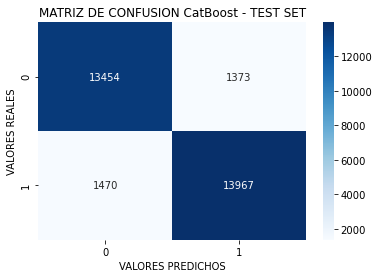

In [43]:
sns.heatmap(confusion_matrix(y_test,best_model.predict(X_test)), annot=True, fmt='4d',cmap='Blues')
plt.xlabel('VALORES PREDICHOS')
plt.ylabel('VALORES REALES')
plt.title('MATRIZ DE CONFUSION CatBoost - TEST SET')
plt.show()


In [44]:
print(classification_report(y_test,best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     14827
           1       0.91      0.90      0.91     15437

    accuracy                           0.91     30264
   macro avg       0.91      0.91      0.91     30264
weighted avg       0.91      0.91      0.91     30264



In [45]:

roc_auc_score(y_test,best_model.predict(X_test))

0.9060864541492842

**Podemos observar que nuestro modelo esta performando bastante bien, para clasificar las victorias del equipo atacante (Terrorist)**

## FEATURE IMPORTANCE

In [46]:
feature_names = df_combinacion.columns
feature_importance = best_model[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(6)

importance_sorted

feature_names  feature_importance
14      ct_armor        60713.316200
15       t_armor        45128.296185
17       t_money        24487.189088
16      ct_money        23945.217514
9      time_left        15754.691238
10      ct_score        14444.035853

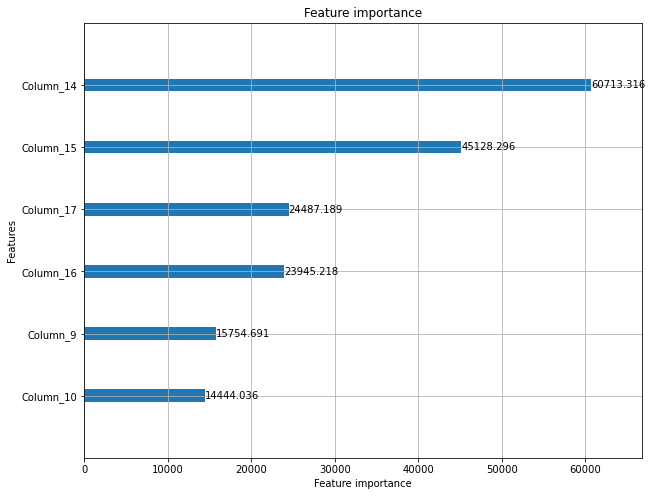

In [47]:
plot_importance(best_model[1], figsize =(10,8), max_num_features=6)
plt.show()

# CONCLUSIONES :

Observamos que la variable que mas influye en la victoria del equipo atacante es la `armadura o chaleco kevlar`, donde, impacta mas en la victoria del equipo atacante, que el equipo defensor no haya podido comprar bien su armadura, a que el equipo defensor lo haga. Esto se debe probablemente a que al momento de atacar se desarrolla una situacion de mayoria numerica del lado atacante frente al defensor, con lo cual, la armadura o chaleco kevlar, cobra mucha relevancia en ésta situacion.

El siguiente atributo que cobra importancia es el `dinero`, tanto como que el equipo atacante tenga una buena economia para equiparse correctamente, asi como tambien que el equipo defensor tenga una mala economia (la diferencia entre estos dos atributos es del 2%).**Ésto nos indica que la mejor estrategia es, mantener una economia sana, y a la vez atacar la economia del equipo defensor, en rondas "economicas", por ejemplo, o en situaciones de 1 vs 4, donde la derrota de la ronda es bastante probable, se puede mejorar las chances de victoria en rondas siguientes, atacando la economia rival**

El siguiente factor que vemos en orden de importancia, es el `tiempo de ronda`.


El siguiente factor que vemos en orden de importancia, es el `score`. Existen 

.Podemos verlo como "NUNCA ALGO ESTA GANADO", scores altos, generan confianza y descuido en los jugadores, incluso en los rangos profesionales, con lo cual, estos descuidos, generan derrotas, que generan perdidas economicas para el equipo y pueden desembocar en una recuperacion del equipo enemigo.**Esto nos indica que debemos mantener la concentracion ignorando el score y la diferencia entre ambos equipos**.



FALTA...

1) Ver pq m4_ct es mas efectiva para que ganenn los terrors, que la ak47.


### **ESTUDIAMOS QUE FEATURES FAVORECEN AL EQUIPO ATACANTE DISCRIMINANDO POR MAPA**

In [48]:
df_de_dust2 = df_combinacion.drop(['de_inferno','de_mirage','de_nuke','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_mirage = df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_nuke = df_combinacion.drop(['de_inferno','de_dust2','de_mirage','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_inferno = df_combinacion.drop(['de_mirage','de_dust2','de_nuke','de_overpass', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_overpass = df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_mirage', 'de_train','de_vertigo','de_cache'], axis=1)
df_de_vertigo = df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_train','de_mirage','de_cache'], axis=1)
df_de_train = df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_mirage','de_vertigo','de_cache'], axis=1)
df_de_cache = df_combinacion.drop(['de_inferno','de_dust2','de_nuke','de_overpass', 'de_train','de_vertigo','de_mirage'], axis=1)


# DE_DUST2

In [49]:
X_train_de_dust2, X_test_de_dust2, y_train_de_dust2, y_test_de_dust2 = \
train_test_split(df_de_dust2, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_dust2=best_model.fit(X_train_de_dust2, y_train_de_dust2)

In [50]:
feature_names = df_de_dust2.columns
feature_importance = model_de_dust2[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61891.761054
8           t_armor        46279.830764
9          ct_money        25055.837121
10          t_money        24956.664736
2         time_left        16055.520794
4           t_score        14746.614667
3          ct_score        13971.038305
6          t_health        10391.743210
12        t_helmets         8907.814402
5         ct_health         8324.140120
15  t_players_alive         5475.509777
13   ct_defuse_kits         5437.505402

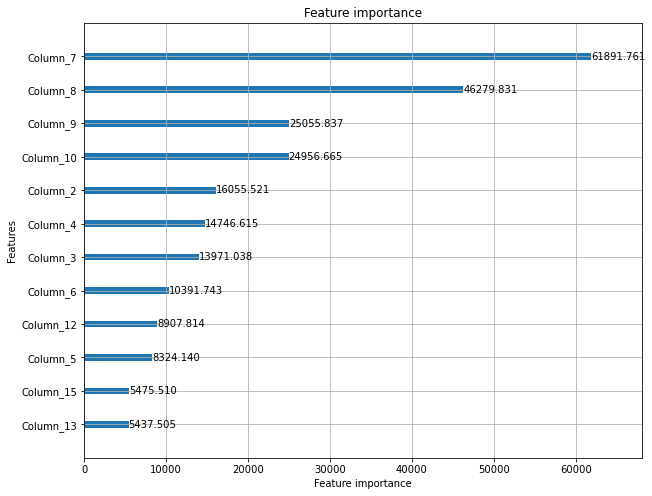

In [51]:
plot_importance(model_de_dust2[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_MIRAGE

In [52]:
X_train_de_mirage, X_test_de_mirage, y_train_de_mirage, y_test_de_mirage = \
train_test_split(df_de_mirage, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_mirage=best_model.fit(X_train_de_mirage, y_train_de_mirage)

In [53]:
feature_names = df_de_mirage.columns
feature_importance = model_de_mirage[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61478.419889
8           t_armor        46413.112924
9          ct_money        25557.626388
10          t_money        25217.316473
2         time_left        16204.064446
4           t_score        14368.259382
3          ct_score        13689.011742
6          t_health        10618.366450
12        t_helmets         9032.843562
5         ct_health         8378.914890
15  t_players_alive         5833.654079
13   ct_defuse_kits         5566.757406

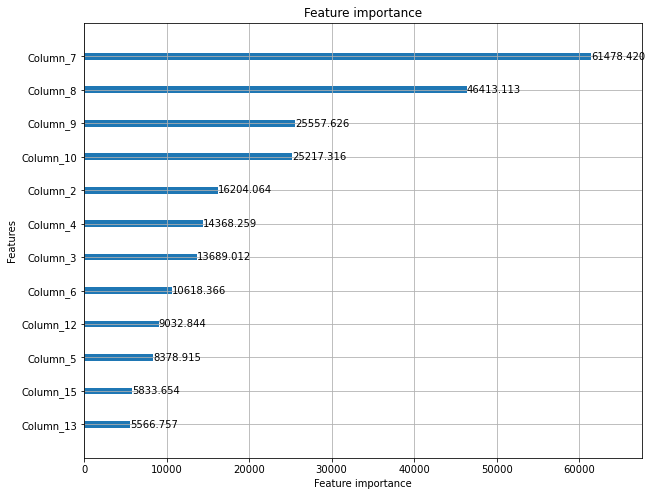

In [54]:
plot_importance(model_de_mirage[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_NUKE

In [55]:
X_train_de_nuke, X_test_de_nuke, y_train_de_nuke, y_test_de_nuke = \
train_test_split(df_de_mirage, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_nuke=best_model.fit(X_train_de_nuke, y_train_de_nuke)

In [56]:
feature_names = df_de_nuke.columns
feature_importance = model_de_nuke[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61478.419889
8           t_armor        46413.112924
9          ct_money        25557.626388
10          t_money        25217.316473
2         time_left        16204.064446
4           t_score        14368.259382
3          ct_score        13689.011742
6          t_health        10618.366450
12        t_helmets         9032.843562
5         ct_health         8378.914890
15  t_players_alive         5833.654079
13   ct_defuse_kits         5566.757406

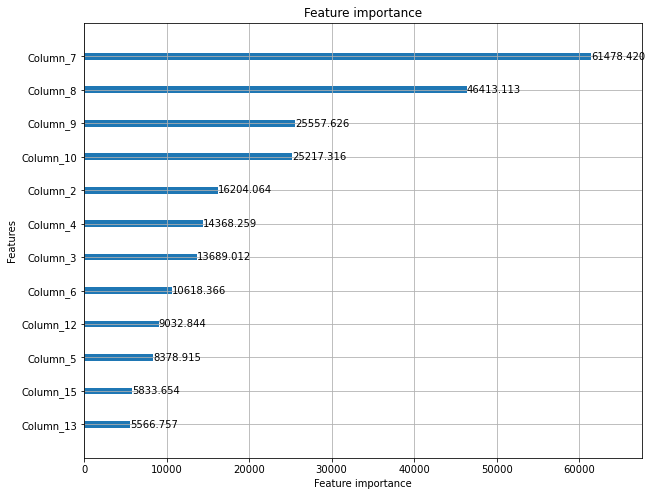

In [57]:
plot_importance(model_de_nuke[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_INFERNO

In [58]:
X_train_de_inferno, X_test_de_inferno, y_train_de_inferno, y_test_de_inferno = \
train_test_split(df_de_inferno, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_inferno=best_model.fit(X_train_de_inferno, y_train_de_inferno)

In [59]:
feature_names = df_de_inferno.columns
feature_importance = model_de_inferno[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61849.896058
8           t_armor        46218.936177
9          ct_money        25554.894056
10          t_money        24953.566094
2         time_left        16314.456522
4           t_score        14415.769125
3          ct_score        14192.327249
6          t_health        10175.803494
12        t_helmets         9006.587573
5         ct_health         8661.167839
15  t_players_alive         5593.452593
76   ct_weapon_usps         5453.854091

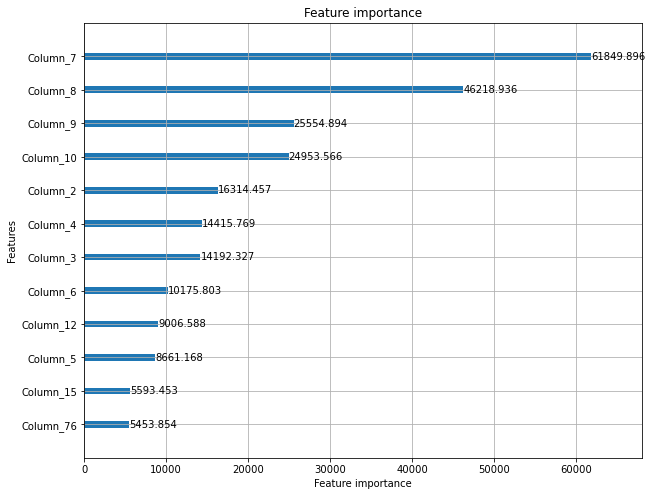

In [60]:
plot_importance(model_de_inferno[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_OVERPASS

In [61]:
X_train_de_overpass, X_test_de_overpass, y_train_de_overpass, y_test_de_overpass = \
train_test_split(df_de_overpass, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_overpass=best_model.fit(X_train_de_overpass, y_train_de_overpass)

In [62]:
feature_names = df_de_overpass.columns
feature_importance = model_de_overpass[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61675.828887
8           t_armor        46321.611366
9          ct_money        25483.129120
10          t_money        25039.783231
2         time_left        15950.393968
4           t_score        14643.701526
3          ct_score        14550.503215
6          t_health        10173.883243
12        t_helmets         8953.853795
5         ct_health         8735.350029
76   ct_weapon_usps         5632.565030
15  t_players_alive         5603.399372

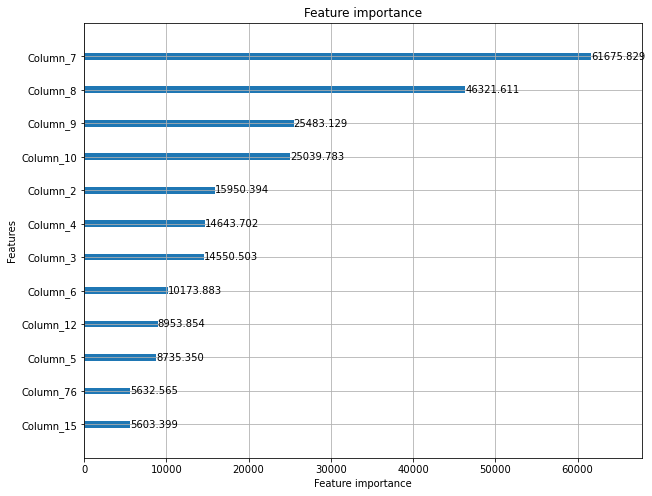

In [63]:
plot_importance(model_de_overpass[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_VERTIGO

In [64]:
X_train_de_vertigo, X_test_de_vertigo, y_train_de_vertigo, y_test_de_vertigo = \
train_test_split(df_de_vertigo, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_vertigo=best_model.fit(X_train_de_vertigo, y_train_de_vertigo)

In [65]:
feature_names = df_de_vertigo.columns
feature_importance = model_de_vertigo[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        62037.715698
8           t_armor        46023.091619
9          ct_money        25479.051484
10          t_money        24773.532488
2         time_left        16350.536197
3          ct_score        14306.658401
4           t_score        14125.840864
6          t_health        10547.979454
12        t_helmets         9043.372912
5         ct_health         8589.842372
15  t_players_alive         5694.911458
13   ct_defuse_kits         5631.148172

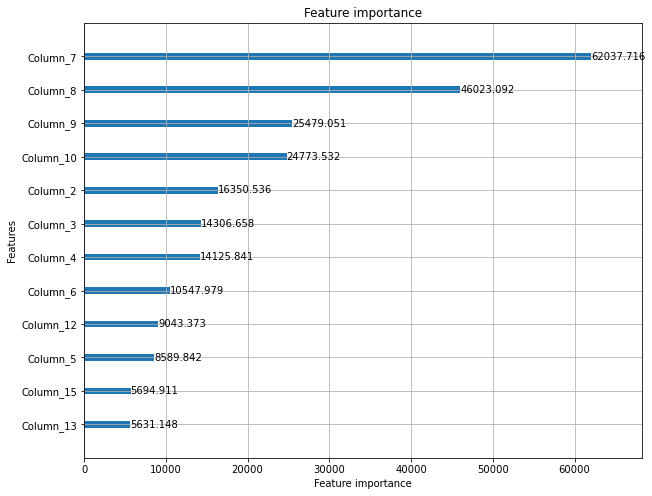

In [66]:
plot_importance(model_de_vertigo[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_TRAIN

In [67]:
X_train_de_train, X_test_de_train, y_train_de_train, y_test_de_train = \
train_test_split(df_de_train, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_train=best_model.fit(X_train_de_train, y_train_de_train)

In [68]:
feature_names = df_de_train.columns
feature_importance = model_de_train[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61355.749148
8           t_armor        45741.800898
9          ct_money        25342.256009
10          t_money        25246.674954
2         time_left        16135.072798
4           t_score        14531.567898
3          ct_score        14308.902935
6          t_health        10552.705019
12        t_helmets         8929.740468
5         ct_health         8475.812400
15  t_players_alive         5702.056006
13   ct_defuse_kits         5487.367577

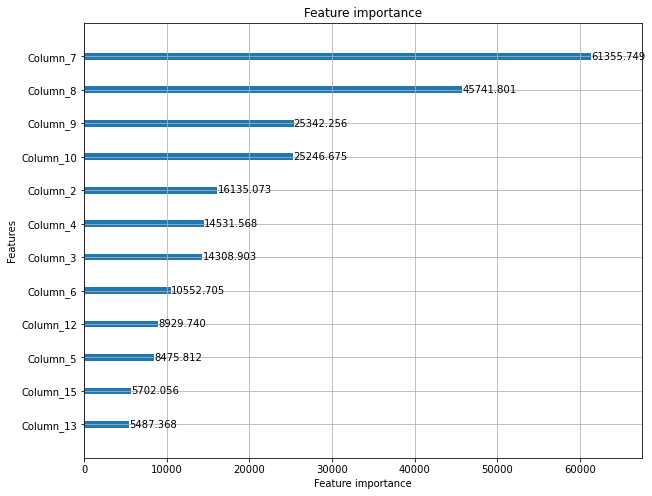

In [69]:
plot_importance(model_de_train[1], figsize =(10,8), max_num_features=12)
plt.show()

# DE_CACHE

In [70]:
X_train_de_cache, X_test_de_cache, y_train_de_cache, y_test_de_cache = \
train_test_split(df_de_cache, df.round_winner, stratify=df.round_winner, random_state = 1203)

model_de_cache=best_model.fit(X_train_de_cache, y_train_de_cache)

In [71]:
feature_names = df_de_cache.columns
feature_importance = model_de_cache[1].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(12)

importance_sorted

feature_names  feature_importance
7          ct_armor        61463.052820
8           t_armor        46700.964346
9          ct_money        25071.274376
10          t_money        24992.033273
2         time_left        16266.353381
3          ct_score        14639.867989
4           t_score        14179.935361
6          t_health        10402.774281
12        t_helmets         9003.720105
5         ct_health         8564.445754
15  t_players_alive         5744.997348
13   ct_defuse_kits         5397.989116

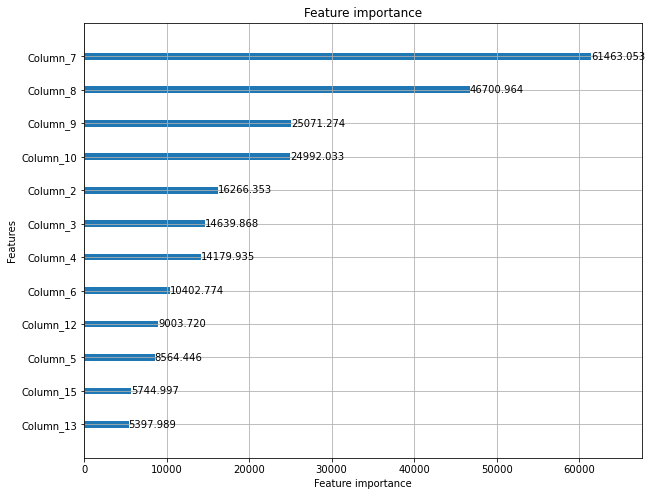

In [72]:
plot_importance(model_de_cache[1], figsize =(10,8), max_num_features=12)
plt.show()

Podemos concluir que **NO HAY** variaciones significativas en las feature importance **EN FUNCION DEL MAPA**

## ANALISIS CON LIME

In [75]:
X_train.head()

0    1    2    3    4    5    6    7    8       9     10   11     12   \
1741   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   54.95   5.0  7.0  400.0   
34656  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   74.91  15.0  6.0  491.0   
49119  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   19.80   3.0  7.0   30.0   
69085  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  175.00  11.0  9.0  500.0   
49895  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   94.94   0.0  0.0  400.0   

         13     14     15       16       17   18   19   20   21   22   23   \
1741   259.0  383.0  298.0   5000.0  24250.0  1.0  4.0  1.0  4.0  4.0  1.0   
34656  472.0  496.0  498.0  11700.0    500.0  5.0  4.0  5.0  5.0  5.0  0.0   
49119  231.0   99.0  249.0    150.0  22500.0  1.0  3.0  0.0  1.0  3.0  0.0   
69085  500.0  200.0  430.0  10200.0  16950.0  1.0  5.0  0.0  5.0  5.0  0.0   
49895  500.0  400.0  300.0    600.0    850.0  0.0  0.0  0.0  4.0  5.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36   37   \
1741   1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49119  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  3.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       38   39   40   41   42   43   44   45   46   47   48   49   50   51   \
1741   0.0  0.0  0.0  0.0  3.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  1.0  0.0  4.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  1.0  0.0   
49119  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       52   53   54   55   56   57   58   59   60   61   62   63   64   65   \
1741   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49119  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       66   67   68   69   70   71   72   73   74   75   76   77   78   79   \
1741   0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34656  0.0  0.0  0.0  0.0  0.0  3.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
49119  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       80   81   82   83   84   85   86   87   88   89   90   91   92   93   \
1741   0.0  0.0  0.0  3.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   
34656  1.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  3.0   
49119  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
69085  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0   
49895  0.0  0.0  0.0  3.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

       94   95   96   97   98   99   100  101  102  
1741   2.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  
34656  1.0  3.0  2.0  3.0  0.0  0.0  1.0  0.0  0.0  
49119  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
69085  5.0  0.0  5.0  0.0  0.0  0.0  5.0  0.0  0.0  
49895  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [80]:
categorical = np.arange(0,9)

explainer = LimeTabularExplainer(np.array(X_train), 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = feature_names, 
                                 categorical_features  = categorical,
                                 discretize_continuous=True, 
                                 discretizer = 'decile')

IndexError: list index out of range

In [ ]:
data_row = np.array(X_test.iloc[2]) # prueba con cualquier valor

explanation = explainer.explain_instance(data_row, best_model[1].predict_proba, num_features=5)



In [ ]:
explanation.show_in_notebook(show_table=True)

In [ ]:
explanation.as_pyplot_figure()

In [ ]:
A = pd.DataFrame({'VERDADEROS_VALORES':y_test.values,
                  'VALORES_PREDICHOS':best_model.predict(X_test),
                  'ERRORES':y_test.values!=best_model.predict(X_test)}
                )
A.sample(5)